# Generating Overfit Tree Models

## Original Prompt

By default, you scikitlearn tree models will grow until every node is pure. To explore this, you are to build different models using the max_depth parameter and determine when the tree begins to overfit the data. For depths from max_depth = 1 until the tree is completed, keep track of the accuracy on training vs. test data and generate a plot with depths as the horizontal axis and accuracy as the vertical axis for train and test data.

Repeat this process with different splits of the data to determine at what depth the tree begins to overfit. Share your results with your peers and discuss your approach to generating the visualization. What are the consequences of this overfitting for your approach to building Decision Trees? We provide a small dataset with health data where your goal is to predict whether or not the individuals survive.

## Translated to Questions and Steps

### Key Questions
- At what depth does the tree begin to overfit data?
- What was your approach to generating the data visualizations?
- What are the consequences of this overfitting for your approach to building trees?

### Steps

#### Data Gathering
- Determine N
    - N is where the tree completes with max depth unbound
    - To determine it, just fit on entire data set with no max depth
- For a number of splits, do the following
    - Make a random train / test split
    - For depths 1 to N, do the following
        - Build a tree
        - Compute accuracy on training and test

Notes
- Number of splits is TBD
    - Start with 20
    - Look at variance vs. number of splits, does it drop off?

#### Data Processing
- Compute mean value over splits to get the average accuracy vs. depth
- Plot accuracy vs. depth for both training and test
- Determine break point in depth demarcating overfit
- Identify takeaways that generalize beyond this problem, in terms of understanding depth & overfit

# Imports

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import warnings
import seaborn as sns

In [111]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set()

# Data Load

In [112]:
data = pd.read_csv("./data/Whickham.txt")

In [113]:
data.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   outcome  1314 non-null   object
 1   smoker   1314 non-null   object
 2   age      1314 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 30.9+ KB


# Feature Naming

In [115]:
X = data[["smoker", "age"]]
y = data["outcome"]

In [116]:
X["smoker"] = X["smoker"].map({"No": 0, "Yes": 1})

# Data Gathering

## Determine Max Tree Depth

In [117]:
unbound_tree = DecisionTreeClassifier(max_depth=None).fit(X, y)
max_depth_limit = unbound_tree.tree_.max_depth
max_depth_limit

14

## Loop Processing

Loop over train/test split and max tree depth
- Collect accuracy per run

In [118]:
num_train_test_splits = 100
max_depth_list = list(range(1, max_depth_limit + 1))
max_depth_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [119]:
def inner_loop_processing(X, y, random_state, max_depth):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=random_state,
    )

    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42).fit(
        X_train, y_train
    )

    metrics = {
        "max_depth": max_depth,
        "training_accuracy": accuracy_score(y_train, dt.predict(X_train)) * 100.0,
        "test_accuracy": accuracy_score(y_test, dt.predict(X_test)) * 100.0,
    }

    return metrics

In [120]:
np.random.seed(42)

training_accuracy = np.zeros(
    shape=(max_depth_limit, num_train_test_splits), dtype=np.float64
)

test_accuracy = np.zeros(
    shape=(max_depth_limit, num_train_test_splits), dtype=np.float64
)

for max_depth in max_depth_list:
    for ksplit in range(num_train_test_splits):
        metrics = inner_loop_processing(X, y, ksplit, max_depth)
        training_accuracy[max_depth - 1][ksplit] = metrics["training_accuracy"]
        test_accuracy[max_depth - 1][ksplit] = metrics["test_accuracy"]

        if ksplit % 50 == 0:
            print(
                "max_depth = %2d ksplit = %2d training acc = %.2f%% test acc = %.2f%%"
                % (
                    max_depth,
                    ksplit,
                    metrics["training_accuracy"],
                    metrics["test_accuracy"],
                )
            )

max_depth =  1 ksplit =  0 training acc = 86.70% test acc = 80.85%


max_depth =  1 ksplit = 50 training acc = 84.77% test acc = 86.63%
max_depth =  2 ksplit =  0 training acc = 86.70% test acc = 80.85%
max_depth =  2 ksplit = 50 training acc = 84.77% test acc = 86.63%
max_depth =  3 ksplit =  0 training acc = 86.70% test acc = 80.85%
max_depth =  3 ksplit = 50 training acc = 84.77% test acc = 86.63%
max_depth =  4 ksplit =  0 training acc = 86.80% test acc = 80.85%
max_depth =  4 ksplit = 50 training acc = 84.77% test acc = 86.32%
max_depth =  5 ksplit =  0 training acc = 87.72% test acc = 81.16%
max_depth =  5 ksplit = 50 training acc = 85.38% test acc = 85.41%
max_depth =  6 ksplit =  0 training acc = 87.82% test acc = 80.55%
max_depth =  6 ksplit = 50 training acc = 86.09% test acc = 85.41%
max_depth =  7 ksplit =  0 training acc = 87.92% test acc = 79.33%
max_depth =  7 ksplit = 50 training acc = 86.09% test acc = 85.41%
max_depth =  8 ksplit =  0 training acc = 87.92% test acc = 79.33%
max_depth =  8 ksplit = 50 training acc = 86.09% test acc = 85

# Data Processing

## Mean Accuracy

Calculate over splits, leaving accuracy vs. tree depth

In [121]:
mean_training_accuracy = np.mean(training_accuracy, axis=1)
mean_test_accuracy = np.mean(test_accuracy, axis=1)

## Plot of Accuracy vs. Tree Depth

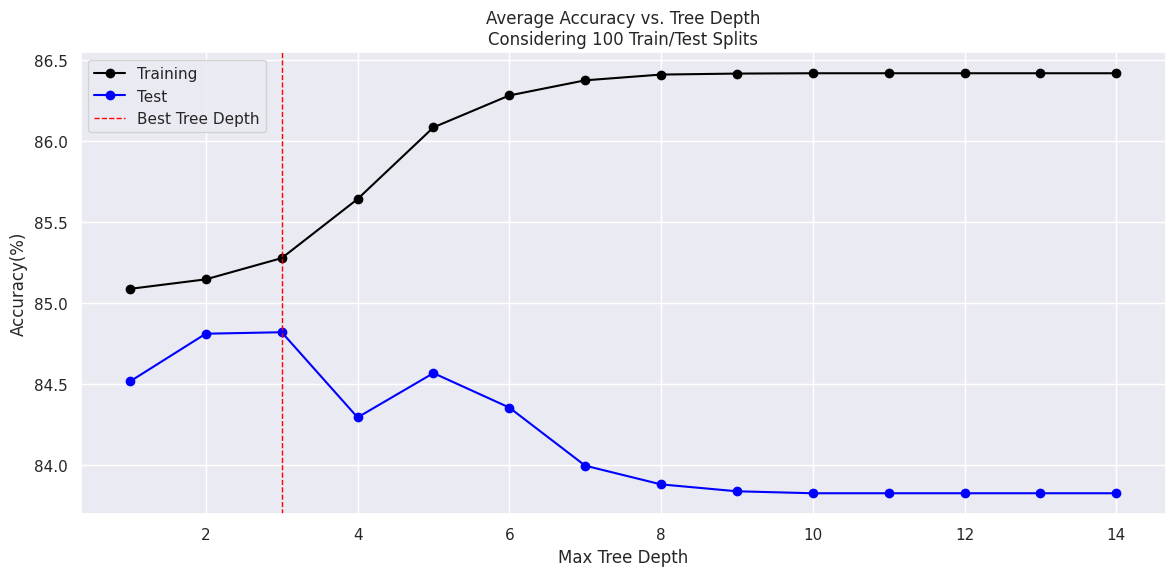

In [122]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    max_depth_list,
    mean_training_accuracy,
    linestyle="solid",
    marker="o",
    color="black",
    label="Training",
)

ax.plot(
    max_depth_list,
    mean_test_accuracy,
    linestyle="solid",
    marker="o",
    color="blue",
    label="Test",
)

ax.axvline(3, label="Best Tree Depth", color="red", linestyle="--", linewidth=1)
ax.grid(True)
ax.set_xlabel("Max Tree Depth")
ax.set_ylabel("Accuracy(%)")
plt.legend()
_ = plt.title(
    "Average Accuracy vs. Tree Depth\nConsidering %d Train/Test Splits"
    % num_train_test_splits
)